In [1]:
import random
import torch
import pandas as pd
import numpy as np
import json
import os
import copy
from torch import nn
from torch.optim import AdamW, Adam
from transformers import AutoModel, AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification
from transformers import RobertaForSequenceClassification
from transformers import RobertaModel
from transformers import get_scheduler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn import metrics as metrics
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import re
from nltk.tokenize import sent_tokenize


random.seed(42)
reprocess_raw =  False

batch_size = 8 # documents
learning_rate = 5e-5
n_epochs = 10

# task_map = {'Quantity':1}
task_map = {'Quantity':1,'MeasuredProperty':2,'MeasuredEntity':3,'Qualifier':4} # uncomment for multi-class
num_classes = len(task_map)

model_name = 'roberta-base'
# model_name = 'bert-base-cased'

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# device = 'cpu' # uncomment this to make debugging easier

data_size_reduce = 1 # multiplier for making small datasets

In [2]:
currentdir = os.getcwd() # ~/MeasEval/baselines

combopath_txt = os.path.join(currentdir, "../data/raw/combo/text/")
combopath_annot = os.path.join(currentdir, "../data/raw/combo/tsv/")

interimpath = os.path.join(currentdir, "../data/interim/")

outputpath = os.path.join(currentdir, "../data/output/")

In [3]:
def process_raw_txt(docs):
    processesd_txt = {}
    remove_markers = True

    cnt_toks = {"figs.": 0, "fig.": 0, "et al.": 0,
            "ref.": 0, "eq.": 0, "e.g.": 0,
            "i.e.": 0, "nos.": 0, "no.": 0,
            "spp.": 0
            }
    regex_end_checker = [".*[a-zA-Z]figs\.$", 
                        ".*[a-zA-Z]fig\.$",
                        ".*[a-zA-Z]et al\.$",
                        ".*[a-zA-Z]ref\.$",
                        ".*[a-zA-Z]eq\.$",
                        ".*[a-zA-Z]e\.g\.$",
                        ".*[a-zA-Z]i\.e\.$",
                        ".*[a-zA-Z]nos\.$",
                        ".*[a-zA-Z]no\.$",
                        ".*[a-zA-Z]spp\.$",
                        # figs., fig., et al., Ref., Eq., e.g., i.e., Nos., No., spp.
                    ]

    assert len(cnt_toks) == len(regex_end_checker)

    for docId, doc in docs.items():
        flag = False
        sentences = sent_tokenize(doc)

        fixed_sentence_tokens = []
        curr_len = 0
        for s in sentences:
            if flag == True:
                assert s[0] != ' '
                white_length = doc[curr_len:].find(s[0])

                prev_len = len(fixed_sentence_tokens[-1])
                fixed_sentence_tokens[-1] = fixed_sentence_tokens[-1] + (" "*white_length) + s

                assert fixed_sentence_tokens[-1][prev_len+white_length] == doc[curr_len+white_length], (fixed_sentence_tokens[-1], doc, curr_len, tmp_this_sent_len)
                tmp_this_sent_len = white_length + len(s)
                assert fixed_sentence_tokens[-1][-1] == doc[curr_len+tmp_this_sent_len-1], (fixed_sentence_tokens[-1], doc, curr_len, tmp_this_sent_len)
                curr_len += tmp_this_sent_len
            else:
                if len(fixed_sentence_tokens) != 0:
                    assert s[0] != ' '
                    white_length = doc[curr_len:].find(s[0])
                    fixed_sentence_tokens.append( (" "*white_length) + s )
                else:
                    fixed_sentence_tokens.append(s)
                assert fixed_sentence_tokens[-1][0] == doc[curr_len], (fixed_sentence_tokens, doc, curr_len, tmp_this_sent_len)
                tmp_this_sent_len = len(fixed_sentence_tokens[-1])
                assert fixed_sentence_tokens[-1][-1] == doc[curr_len+tmp_this_sent_len-1], (fixed_sentence_tokens[-1], doc, curr_len, tmp_this_sent_len)
                curr_len += tmp_this_sent_len

            lower_cased_s = fixed_sentence_tokens[-1].lower()
            flag = False
            if remove_markers:
                for i, k in enumerate(cnt_toks):
                    this_regex_pattern = regex_end_checker[i]
                    if lower_cased_s.endswith(k) and re.match(this_regex_pattern, lower_cased_s) == None:
                        cnt_toks[k] += 1
                        flag = True
                        break

        processesd_txt[docId] = ''.join(fixed_sentence_tokens)
    return processesd_txt


In [4]:
def read_data(reprocess_raw = False):

    if reprocess_raw == True:
        docIds = []
        combo_txt = {}
        for fn in os.listdir(combopath_txt):
            docIds.append(fn[:-4])
            path = combopath_txt+fn
            with open(path) as textfile:
                    text = textfile.read()
                    #[:-4] strips off the .txt to get the id
                    combo_txt[fn[:-4]] = text

        combo_annot = pd.DataFrame()
        for fn in os.listdir(combopath_annot):
            path = combopath_annot+fn
            file = pd.read_csv(path,delimiter='\t',encoding='utf-8')
            combo_annot = pd.concat([combo_annot, file],ignore_index=True)

        combo_txt = process_raw_txt(combo_txt)
        assert docIds == list(combo_txt.keys()), (len(docIds), len(list(combo_txt.keys())))

        with open(interimpath+'combo_txt.json','w') as f:
            json.dump(combo_txt, f)

        combo_annot.to_csv(interimpath+'combo_annot.csv')

        return docIds, combo_txt, combo_annot
    else:
        combo_annot = pd.read_csv(interimpath+'combo_annot.csv')

        with open(interimpath+'combo_txt.json','r') as f:
            combo_txt = json.load(f)

        docIds = list(combo_txt.keys())
    
        return docIds, combo_txt, combo_annot

In [5]:
combo_docs, combo_txt, combo_annot = read_data(reprocess_raw = reprocess_raw)

In [6]:
#### train/dev/test split options

random.seed(42)

percent_to_test = .1
percent_to_dev = .2
percent_to_train =  1 - percent_to_dev - percent_to_test

n_doc = len(combo_docs)
split_train = int(np.round(n_doc * percent_to_train))
split_dev = split_train + int(np.round(n_doc * percent_to_dev))

train_docs = combo_docs[:split_train]
dev_docs = combo_docs[split_train:split_dev]
test_docs = combo_docs[split_dev:]

train_docs = random.sample(train_docs, int(len(train_docs)*data_size_reduce))
dev_docs = random.sample(dev_docs, int(len(dev_docs)*data_size_reduce))
test_docs = random.sample(test_docs, int(len(test_docs)*data_size_reduce))

In [7]:
########## Tokenizer ###########

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [8]:
def process_annotation_set(annot_set):

    annot_set_processed = []

    annot_set['comboIds'] = annot_set[['docId','annotId']].agg('_'.join, axis=1)
    annot_set.set_index('comboIds',inplace=True)

    for comboId in list(annot_set.index):
        
        docId = annot_set.loc[comboId]['docId']
        annotId = annot_set.loc[comboId]['annotId']
        annotSet = annot_set.loc[comboId]['annotSet']
        annotType = annot_set.loc[comboId]['annotType']
        annotSpan = [annot_set.loc[comboId]['startOffset'],annot_set.loc[comboId]['endOffset']]

        ent_annot_processed = {
            'comboId':comboId,
            'docId':docId,
            'annotId':annotId,
            'annotSet':annotSet,
            'annotType':annotType,
            'annotSpan':annotSpan,
            'subSpanType':np.nan,
            'linkId':np.nan,
            'linkSpan':np.nan,
            'subSpan':np.nan,
            'unit':np.nan,
            'unitEncoded':np.nan,
            'misc':np.nan
        }
        
        other = annot_set.loc[comboId]['other']
        if isinstance(other,str):
            otherDict = json.loads(str(other))

            if annot_set.loc[comboId]['annotType'] != 'Quantity':

                ent_annot_processed['subSpanType'] = list(otherDict.keys())[0]
                link = list(otherDict.values())[0]

                ent_annot_processed['linkId'] = link
                linkIdx = docId+'_'+link
                linkSpan = [int(annot_set.loc[linkIdx]['startOffset']),int(annot_set.loc[linkIdx]['endOffset'])]
                ent_annot_processed['linkSpan'] = linkSpan

                spanEnds = annotSpan + linkSpan
                ent_annot_processed['subSpan'] = [min(spanEnds),max(spanEnds)]

            elif 'unit' in list(otherDict.keys()):
                unit = otherDict['unit']
                ent_annot_processed['unit'] = unit
                ent_annot_processed['unitEncoded'] = tokenizer.encode(unit)[1:-1]
            else:
                ent_annot_processed['misc'] = otherDict


        annot_set_processed.append(ent_annot_processed)
   
    return pd.DataFrame.from_dict(annot_set_processed).set_index('comboId')

combo_annot_processed = process_annotation_set(combo_annot)
combo_annot_processed.to_csv(interimpath+'combo_annot_processed.csv')
combo_annot_processed.sample(7)


,docId,annotId,annotSet,annotType,annotSpan,subSpanType,linkId,linkSpan,subSpan,unit,unitEncoded,misc
comboId,,,,,,,,,,,,
S0167577X14001256-517_T1-1,S0167577X14001256-517,T1-1,1,Quantity,"[355, 365]",NaN,NaN,NaN,NaN,nJ,"[282, 863]",NaN
S0167880913001229-1304_T4-3,S0167880913001229-1304,T4-3,3,MeasuredProperty,"[447, 452]",HasQuantity,T1-3,"[439, 446]","[439, 452]",NaN,NaN,NaN
S0378112713005288-1800_T4-6,S0378112713005288-1800,T4-6,6,MeasuredProperty,"[971, 989]",HasQuantity,T1-6,"[953, 965]","[953, 989]",NaN,NaN,NaN
S0019103512002801-1342_T23-3,S0019103512002801-1342,T23-3,3,Qualifier,"[162, 179]",Qualifies,T43-3,"[133, 145]","[133, 179]",NaN,NaN,NaN
S0167739X12001525-6016_T3-3,S0167739X12001525-6016,T3-3,3,MeasuredProperty,"[501, 525]",HasQuantity,T1-3,"[473, 490]","[473, 525]",NaN,NaN,NaN
S0012821X12004384-1284_T104-10,S0012821X12004384-1284,T104-10,10,MeasuredEntity,"[1689, 1707]",HasProperty,T94-10,"[1658, 1681]","[1658, 1707]",NaN,NaN,NaN
S0168945213001805-4775_T2-4,S0168945213001805-4775,T2-4,4,MeasuredProperty,"[885, 901]",HasQuantity,T1-4,"[905, 910]","[885, 910]",NaN,NaN,NaN


In [9]:
### insert special tokens for subspans (Sam)
# will make docs longer

# def char_map(doc_annot, task_map)


def tokenize_and_align_labels(
                                doc_list=combo_docs,
                                txt=combo_txt,
                                processed_annotation=combo_annot_processed,
                                tokenizer=tokenizer,
                                taskLabelMap=task_map
                            ):

    toks_with_labels = []
    special_ids = tokenizer.all_special_ids
    collisionDict = {}

    for doc in doc_list:
        within_doc_collision_count = 0
        # print(doc)
        # print(processed_annotation.loc[processed_annotation['docId'] == doc])
        doc_annot = processed_annotation.loc[processed_annotation['docId'] == doc]
        doc_annot.set_index('annotId',inplace=True)
        # print(doc_annot)

        encoded_txt = tokenizer(txt[doc], padding='max_length', max_length=512, truncation=True)
        encoded_tokens = encoded_txt['input_ids']
        # print(encoded_tokens)

        ############### Label Primary Spans ###############

        labelIds = np.full(len(encoded_tokens),-1)
        taskCharMap = {} # 
        taskCharList = []
        collision = False

        if len(doc_annot) > 0:
            for annot_idx in range(int(doc_annot['annotSet'].max())):
                # print(annot_idx)
                if collision:
                    taskCharMap = taskCharMapBackup
                taskCharMapBackup = copy.deepcopy(taskCharMap)
                collision = False
                spans = list(doc_annot.loc[doc_annot['annotSet']==annot_idx+1]['annotSpan'])
                annotset_tasks = list(doc_annot.loc[doc_annot['annotSet']==annot_idx+1]['annotType'])
                for i in range(len(spans)):
                    span = spans[i]
                    annotset_task = annotset_tasks[i]
                    # print(span)
                    # print(annotset_task)
                    if annotset_task in taskLabelMap.keys():
                        for spanCharIdx in span:
                            if spanCharIdx in taskCharMap:
                                if taskCharMap[spanCharIdx] != taskLabelMap[annotset_task]:
                                    # print("="*45)
                                    # print("Collision detected in doc",doc)
                                    # print("Previous mapped task:",taskCharMap[spanCharIdx],"new mapped task:",taskLabelMap[annotset_task])
                                    # print("Current span:",span)
                                    # print("Second (offending) annotSet will not be included.")
                                    # print("="*45)
                                    collisionDict[doc + '_' + 
                                                  str(within_doc_collision_count 
                                                      + 1)] = span
                                    collision = True
                                    within_doc_collision_count += 1
                                    break
                            # print(spanCharIdx)
                            taskCharMap[spanCharIdx] = taskLabelMap[annotset_task]
                        if collision:
                            continue
                    else:
                        continue
    
                        # print(taskCharMap)
                            # taskAnnotIdCharMap[spanCharIdx] = annotId
            

        decoded = [''] * len(encoded_tokens)
        for tokenIdx, token in enumerate(encoded_tokens):
            
            if token not in special_ids:
                tokenCharStart = encoded_txt.token_to_chars(tokenIdx).start
                if tokenCharStart in list(taskCharMap.keys()):
                    labelIds[tokenIdx] = taskCharMap[tokenCharStart]
                    decoded[tokenIdx] = tokenizer.decode(token)
                else:
                    labelIds[tokenIdx] = 0
            else:
                labelIds[tokenIdx] = 0
        

        ############### Sub Spans Token Insertion and labeling ###############

        encoded_txt['doc_or_sent_id'] = doc
        encoded_txt['labels'] = labelIds
        
        toks_with_labels.append(encoded_txt)
        
    print("Total collisions avoided:", len(collisionDict))
    
    # return toks_with_labels
    return pd.DataFrame.from_dict(toks_with_labels), collisionDict

In [10]:
################# TOKENIZE #################

stage1_train_ds, train_collisions = tokenize_and_align_labels(
    doc_list=train_docs,
    txt=combo_txt,
    processed_annotation=combo_annot_processed,
    tokenizer=tokenizer,
    taskLabelMap=task_map)
# stage1_train_ds.to_csv(interimpath+'stage1_train_ds.csv')
stage1_n_train = stage1_train_ds.shape[0]


stage1_dev_ds, dev_collisions = tokenize_and_align_labels(
    doc_list=dev_docs,
    txt=combo_txt,
    processed_annotation=combo_annot_processed,
    tokenizer=tokenizer,
    taskLabelMap=task_map)
# stage1_dev_ds.to_csv(interimpath+'stage1_dev_ds.csv')
stage1_n_dev = stage1_dev_ds.shape[0]

stage1_test_ds, test_collisions = tokenize_and_align_labels(
    doc_list=test_docs,
    txt=combo_txt,
    processed_annotation=combo_annot_processed,
    tokenizer=tokenizer,
    taskLabelMap=task_map)
# stage1_test_ds.to_csv(interimpath+'stage1_test_ds.csv')
stage1_n_test = stage1_test_ds.shape[0]


Total collisions avoided: 136
Total collisions avoided: 33
Total collisions avoided: 4


In [11]:
stage1_n_train

314

In [12]:
### Matt
# def shorten_txt_encoding(txt, shorten_by : int):       
#     pass...

# generate a list of docIds that have token collision after shortening

# toks = list(stage1_dev_ds.sample(1)['input_ids'])

# print(toks[0])

# tokenizer.decode(toks[0])

In [13]:
def batchify(tokenized_dataset, batch_size, device):
    num_examples = int(tokenized_dataset.shape[0] / batch_size)
    batch_sizes = [batch_size for x in range(num_examples)]
    last_batch_size = tokenized_dataset.shape[0] % batch_size
    if last_batch_size:
        batch_sizes.append(last_batch_size)
    # print(batch_sizes)

    batched_dataset = []

    idf_to_torch = lambda df : torch.tensor(np.array([list(map(int,r)) for r in df])).to(device)

    for idx, size in enumerate(batch_sizes):
        start = sum(batch_sizes[:idx])
        end = sum(batch_sizes[:idx]) + size - 1
        # print(start,end,idx)
        input_ids = idf_to_torch(tokenized_dataset['input_ids'].loc[start:end])
        attention_mask = idf_to_torch(tokenized_dataset['attention_mask'].loc[start:end])
        labels = idf_to_torch(tokenized_dataset['labels'].loc[start:end])
        doc_or_sent_id = list(tokenized_dataset['doc_or_sent_id'].loc[start:end])
        
        batch = {
            'input_ids':input_ids,
            'labels':labels,
            'attention_mask':attention_mask,
            'doc_or_sent_id':doc_or_sent_id

        }
        
        batched_dataset.append(batch)

    return batched_dataset

In [14]:
################# batchify ####################

batched_train_ds = batchify(stage1_train_ds[['attention_mask','input_ids','labels','doc_or_sent_id']], batch_size, device)
batched_dev_ds = batchify(stage1_dev_ds[['attention_mask','input_ids','labels','doc_or_sent_id']], batch_size, device)
batched_test_ds = batchify(stage1_test_ds[['attention_mask','input_ids','labels','doc_or_sent_id']], batch_size, device)


In [15]:
batched_train_ds[0]

{'input_ids': tensor([[    0, 44105,     4,  ...,     1,     1,     1],
         [    0,   970,    32,  ...,     1,     1,     1],
         [    0,   170,   220,  ...,     1,     1,     1],
         ...,
         [    0,   500, 26343,  ...,     1,     1,     1],
         [    0, 44105,     4,  ...,     1,     1,     1],
         [    0, 14699,    12,  ...,     1,     1,     1]], device='cuda:0'),
 'labels': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 3, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 3, 0,  ..., 0, 0, 0]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0'),
 'doc_or_sent_id': ['S0016236113008041-3290',
  'S0006322312001096-1271',
  'S00220000

In [16]:
demo_batch = 2

demo_batch = batched_train_ds[demo_batch]


demo_doc = demo_batch['doc_or_sent_id'][0]
demo_ids = demo_batch['input_ids'].cpu().numpy()[0]
demo_tokens = tokenizer.decode(demo_batch['input_ids'].cpu().numpy()[0])
demo_labels = demo_batch['labels'].cpu().numpy()[0]
demo_mask = demo_batch['attention_mask'].cpu().numpy()[0]
latch_print = False
labeled_tokens = ''
for id, lab in zip(demo_ids, demo_labels):
    if lab:
        labeled_tokens = labeled_tokens + tokenizer.decode(id) + ' '

print(task_map)


{'Quantity': 1, 'MeasuredProperty': 2, 'MeasuredEntity': 3, 'Qualifier': 4}


In [17]:
demo_doc

'S0301010413004096-693'

In [18]:
print(demo_ids)

[    0 44791  2383 34098  7208    36  8756   597    43 34003    32    10
  2849    12  4684     9 35443  9281  7823    61   311   372  4198    13
  1123  3521     8 10875   528     7    49   239  4084   443     6   614
  7208 16522     6     8  8859   868 12628   181  1688  1737   646   246
  8174 11757   597  3183    32  2333  1490    62    31  4204 41985    50
 28255 30987  4462    30  6523  3104   268     7  4960   155   495  3112
 32480    19     5  9285     9 32426  2192  6272    31 14926  6884 24477
     7 10969  1517 24477   976     4  3646   453   624    42 11757   597
   284    33  4824 13113  6608   239   289   176  5814   368 24802 23549
    36 41324    23  8930 23982  3971     6  3700    23  6791   229    43
   646   306   742    19    10   638     9 49447  1549   885    90   207
   746 33646  2148  6373    11   234   791    12  1866   646   245   742
     8 11757   597    12  2619   646   401  8174   635     6   209   239
 33646 23549  1874  8617    19  2284  5181     6   

In [19]:
print(demo_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0
 3 0 2 2 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [20]:
print(demo_tokens)

<s>Metal–organic framework (MOF) complexes are a sub-class of porous solids which show great promise for gas storage and separation due to their high surface area, low framework density, and tuneable functional pore environment [3]. MOF materials are usually built up from metal ions or clusters bridged by organic linkers to afford 3D extended frameworks with the formation of cavities ranging from microporous to mesoporous region. Several members within this MOF family have achieved impressively high H2 adsorption capacities (albeit at cryogenic temperatures, typically at 77 K) [4] with a record of ∼16 wt% total uptake capacity observed in NU-100 [5] and MOF-200 [6]. However, these high uptake capacities drop dramatically with increasing temperature, and thus none is a practical material. There is thus particular emphasis on optimising the interactions between MOF hosts and adsorbed H2 molecules, and the identification of specific binding interactions and properties of gases within conf

In [21]:
combo_annot_processed.loc[combo_annot['docId']==demo_doc]

,docId,annotId,annotSet,annotType,annotSpan,subSpanType,linkId,linkSpan,subSpan,unit,unitEncoded,misc
comboId,,,,,,,,,,,,
S0301010413004096-693_T1-1,S0301010413004096-693,T1-1,1,Quantity,"[575, 579]",NaN,NaN,NaN,NaN,K,[530],NaN
S0301010413004096-693_T3-1,S0301010413004096-693,T3-1,1,MeasuredProperty,"[548, 560]",HasQuantity,T1-1,"[575, 579]","[548, 579]",NaN,NaN,NaN
S0301010413004096-693_T4-1,S0301010413004096-693,T4-1,1,MeasuredEntity,"[538, 547]",HasProperty,T3-1,"[548, 560]","[538, 560]",NaN,NaN,NaN
S0301010413004096-693_T1-2,S0301010413004096-693,T1-2,2,Quantity,"[602, 609]",NaN,NaN,NaN,NaN,wt%,"[43192, 207]",NaN
S0301010413004096-693_T3-2,S0301010413004096-693,T3-2,2,MeasuredProperty,"[610, 631]",HasQuantity,T1-2,"[602, 609]","[602, 631]",NaN,NaN,NaN
S0301010413004096-693_T4-2,S0301010413004096-693,T4-2,2,MeasuredEntity,"[502, 504]",HasProperty,T3-2,"[610, 631]","[502, 631]",NaN,NaN,NaN
S0301010413004096-693_T5-2,S0301010413004096-693,T5-2,2,Qualifier,"[431, 469]",Qualifies,T3-2,"[610, 631]","[431, 631]",NaN,NaN,NaN
S0301010413004096-693_T1-3,S0301010413004096-693,T1-3,3,Quantity,"[1174, 1184]",NaN,NaN,NaN,NaN,K,[530],NaN
S0301010413004096-693_T3-3,S0301010413004096-693,T3-3,3,MeasuredEntity,"[1130, 1170]",HasQuantity,T1-3,"[1174, 1184]","[1130, 1184]",NaN,NaN,NaN


In [22]:
print(labeled_tokens)

 Several  H  cry  temperatures ,  77 )  ∼  total  In  below 


In [23]:
special_token_map = dict(zip(tokenizer.all_special_tokens,tokenizer.all_special_ids))
special_token_map

{'<s>': 0, '</s>': 2, '<unk>': 3, '<pad>': 1, '<mask>': 50264}

In [24]:
demo_annots = combo_annot_processed.loc[combo_annot['docId']==demo_doc]

demo_txt = combo_txt[demo_doc]

encoded_demo_txt = tokenizer(demo_txt, padding='max_length', max_length=512, truncation=True)
demo_token_startchar = []
for idx, id in enumerate(encoded_demo_txt['input_ids']):
    try: tokenCharStart = encoded_demo_txt.token_to_chars(idx).start
    except: tokenCharStart = np.nan
    demo_token_startchar.append(tokenCharStart)

subSpan_ds = {}
for comboId, annot in demo_annots.iterrows():
    if isinstance(annot['subSpanType'],float): continue # nans are floats
    print(comboId)
    print(annot['annotType'])
    print(annot['subSpanType'])
    print(annot['subSpan'][0],annot['subSpan'][1])
    subSpanRange = list(range(annot['subSpan'][0],annot['subSpan'][1]))
    # print(subSpanRange)
    subSpanIds = []
    subSpanLabels = []
    for id, label, startChar in zip(demo_ids, demo_labels, demo_token_startchar):
        if startChar in subSpanRange:
            subSpanIds.append(id)
            subSpanLabels.append(label)
    print(subSpanIds)
    print(subSpanLabels)
    print(tokenizer.decode(subSpanIds,skip_special_tokens=True))
    print()



S0301010413004096-693_T3-1
MeasuredProperty
HasQuantity
548 579
[3971, 6, 3700, 23, 6791, 229]
[2, 2, 0, 0, 1, 0]
 temperatures, typically at 77 K

S0301010413004096-693_T4-1
MeasuredEntity
HasProperty
538 560
[8930, 23982, 3971]
[3, 0, 2]
 cryogenic temperatures

S0301010413004096-693_T3-2
MeasuredProperty
HasQuantity
602 631
[49447, 1549, 885, 90, 207, 746, 33646, 2148]
[1, 0, 0, 0, 0, 2, 0, 0]
 ∼16 wt% total uptake capacity

S0301010413004096-693_T4-2
MeasuredEntity
HasProperty
502 631
[289, 176, 5814, 368, 24802, 23549, 36, 41324, 23, 8930, 23982, 3971, 6, 3700, 23, 6791, 229, 43, 646, 306, 742, 19, 10, 638, 9, 49447, 1549, 885, 90, 207, 746, 33646, 2148]
[3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 2, 2, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0]
 H2 adsorption capacities (albeit at cryogenic temperatures, typically at 77 K) [4] with a record of ∼16 wt% total uptake capacity

S0301010413004096-693_T5-2
Qualifier
Qualifies
431 631
[3646, 453, 624, 42, 11757, 597, 284, 33, 482

In [25]:
combo_txt[demo_doc][1391:1458]

'tal centres, and that the adsorbed D2 molecules have molecular sepa'

In [26]:
class Stage1model(nn.Module):
    def __init__(self, dropout=0.1):
        super(Stage1model, self).__init__()
        self.mod = RobertaModel.from_pretrained(
                    model_name,
                    num_labels=num_classes+1,
                    hidden_dropout_prob=dropout,
                    output_hidden_states=True)
        self.norm = nn.BatchNorm1d(512, eps=self.mod.config.layer_norm_eps)
        self.drop = nn.Dropout(self.mod.config.hidden_dropout_prob)
        self.classifier = nn.Linear(self.mod.config.hidden_size, num_classes+1)

    def forward(self, input_ids, attention_mask):
        output = self.mod(input_ids=input_ids,attention_mask=attention_mask)
        y_hat = output.hidden_states[-1]
        y_hat = self.norm(y_hat)
        y_hat = self.drop(y_hat)
        y_hat = self.classifier(y_hat).permute(0,2,1)
        return y_hat

model = Stage1model().to(device)

model_new = model


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
model_new

Stage1model(
  (mod): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), e

In [28]:


# class OurBERTModel(nn.Module):
#     def __init__(self):
#         super(OurBERTModel, self).__init__()
#         self.mod = AutoModel.from_pretrained(model_name, num_labels=num_classes+1)
#         self.drop = nn.Dropout(self.mod.config.hidden_dropout_prob)
#         self.classifier = nn.Linear(self.mod.config.hidden_size, num_classes+1)

#     def forward(self, text, att_mask):
#         b, num_tokens = text.shape
#         token_type = torch.zeros((b, num_tokens), dtype=torch.long).to(device)
#         outputs = self.mod(text, attention_mask=att_mask, token_type_ids=token_type)
#         return self.classifier(self.drop(outputs['last_hidden_state']))

# model = OurBERTModel().to(device)

# model_old = model

In [29]:
# model_old

In [30]:
# demo_logits = model(demo_batch['input_ids'], demo_batch['attention_mask'])

In [31]:
# demo_logits.permute(0,2,1).shape

In [32]:
# demo_batch['labels'].shape

In [33]:
# ypred = []
# ytrue = []
# for dlabels, dlogits in zip(demo_batch['labels'], demo_logits.permute(0,2,1)):
#     print(dlabels.shape)
#     print(dlogits.shape)
#     for tlogits, tlabels in zip(dlogits, dlabels):
#         print(tlabels.shape)
#         print(tlogits.shape)
#         ypred.append(tlogits.argmax().item())
#         ytrue.append(tlabels.item())
#         print(ypred)
#         print(ytrue)
        

In [34]:
criterion = torch.nn.CrossEntropyLoss(reduction='sum')
optimizer = AdamW(model.parameters(), lr=learning_rate)

n_training_steps = n_epochs * len(batched_train_ds)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=n_training_steps
)


def train_epoch(ds, criterion):

    model.train()

    ypred = []
    ytrue = []
    for idx, batch in enumerate(ds):

        labels = batch['labels']
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        
        optimizer.zero_grad()

        logits = model(input_ids, attention_mask)
        
        loss = criterion(logits, labels)
        # loss = (loss * attention_mask).sum() / (attention_mask).sum()
        
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        progress_bar.update(1)
            
    return loss.item()



def eval_epoch(ds, criterion):

    model.eval()

    ypred = []
    ytrue = []
    with torch.no_grad():
        for idx, batch in enumerate(ds):

            labels = batch['labels']
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']

            logits = model(input_ids, attention_mask)
            
            loss = criterion(logits, labels)
            # loss = (loss * attention_mask).sum() / (attention_mask).sum()

            for dlogits, dlabels in zip(logits.permute(0,2,1), labels):
                    for tlogits, tlabels in zip(dlogits, dlabels):
                        ypred.append(tlogits.argmax().item())
                        ytrue.append(tlabels.item())

            progress_bar.update(1)

    acc = metrics.accuracy_score(ytrue,ypred)
    report = classification_report(ytrue,ypred,
                                    labels=list(task_map.values()),
                                    target_names=list(task_map.keys()),
                                    output_dict=True,
                                    zero_division=0)

                                    

    return loss.item(), acc, report, ytrue, ypred

In [35]:
run_report = {  'epoch':[],
                'train_loss':[],
                'eval_train_loss':[],
                'eval_train_acc':[],
                'eval_train_ytrue':[],
                'eval_train_ypred':[],
                'eval_train_rpt':[],
                'eval_dev_loss':[],
                'eval_dev_acc':[],
                'eval_dev_ytrue':[],
                'eval_dev_ypred':[],
                'eval_dev_rpt':[],
             }

num_total_steps = n_epochs * (len(batched_train_ds) * 2 + len(batched_dev_ds))
progress_bar = tqdm(range(num_total_steps))

for epoch in range(n_epochs):
    run_report['epoch'].append(epoch)
    
    print(f"============ Begin Epoch {epoch+1} ============")

    loss = train_epoch(batched_train_ds, criterion)
    print(f"Train loss: {loss}")
    run_report['train_loss'].append(loss)
    
    output = eval_epoch(batched_train_ds, criterion)
    (loss, acc, report, ytrue, ypred) = output
    print(f'Eval on train set loss: {loss}   accuracy: {acc}')
    run_report['eval_train_loss'].append(loss)
    run_report['eval_train_acc'].append(acc)
    run_report['eval_train_ytrue'].append(ytrue)
    run_report['eval_train_ypred'].append(ypred)
    run_report['eval_train_rpt'].append(report)

    output = eval_epoch(batched_dev_ds, criterion)
    (loss, acc, report, ytrue, ypred) = output
    print(f'Eval on dev set loss: {loss}   accuracy: {acc}')
    run_report['eval_dev_loss'].append(loss)
    run_report['eval_dev_acc'].append(acc)
    run_report['eval_dev_ytrue'].append(ytrue)
    run_report['eval_dev_ypred'].append(ypred)
    run_report['eval_dev_rpt'].append(report)
    


  0%|          | 0/920 [00:00<?, ?it/s]

============ Begin Epoch 1 ============
Train loss: 72.65139770507812
Eval on train set loss: 71.22679138183594   accuracy: 0.977781648089172
Eval on dev set loss: 152.74609375   accuracy: 0.9794487847222222
============ Begin Epoch 2 ============
Train loss: 54.53330993652344
Eval on train set loss: 43.23786926269531   accuracy: 0.9803381269904459
Eval on dev set loss: 104.6290283203125   accuracy: 0.9807508680555556
============ Begin Epoch 3 ============
Train loss: 31.65301513671875
Eval on train set loss: 31.508602142333984   accuracy: 0.984070212977707
Eval on dev set loss: 82.0683364868164   accuracy: 0.9833116319444445
============ Begin Epoch 4 ============
Train loss: 20.61083221435547
Eval on train set loss: 18.85871696472168   accuracy: 0.9878085191082803
Eval on dev set loss: 71.9001235961914   accuracy: 0.9852430555555556
============ Begin Epoch 5 ============
Train loss: 22.31936264038086
Eval on train set loss: 19.04261016845703   accuracy: 0.9889841261942676
Eval on d

[[44862    90    78    93    10]
 [   49   331     1     3     0]
 [   69     4    88    17     5]
 [  103     9    43   130     1]
 [   51     5    14    14    10]]


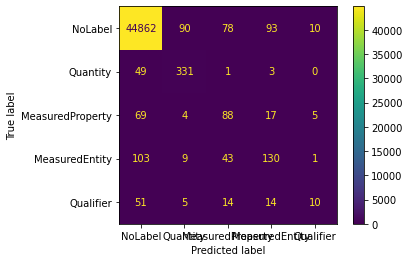

In [36]:
display_labels = list(task_map.keys())
display_labels.insert(0,str('NoLabel'))
cm = confusion_matrix(ytrue,ypred)
print(cm)
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=display_labels).plot()
plt.show()

In [37]:
len(ypred)/512

90.0

In [38]:
ypred_save = ypred

In [39]:
len(ypred_save)

46080

In [40]:
ypred_by_doc = {}
ytrue_by_doc = {}
for i, doc in enumerate(dev_docs):

    ypred_by_doc[doc] = ypred[i*512:(i+1)*512]
    ytrue_by_doc[doc] = ytrue[i*512:(i+1)*512]


    print(f'aligned {len(ypred_by_doc[doc])} predictions into doc {doc}')

aligned 512 predictions into doc S0927024813002961-1334
aligned 512 predictions into doc S1873506114000075-1132
aligned 512 predictions into doc S2211124713006475-841
aligned 512 predictions into doc S2211124713006475-1195
aligned 512 predictions into doc S0960148113004989-3327
aligned 512 predictions into doc S1387700313001822-661
aligned 512 predictions into doc S0950705113001895-23137
aligned 512 predictions into doc S1873506113001116-1456
aligned 512 predictions into doc S0960148113005727-1181
aligned 512 predictions into doc S1873506113001116-978
aligned 512 predictions into doc S2211124713006475-741
aligned 512 predictions into doc S0927024813002961-1051
aligned 512 predictions into doc S0927024813003036-1981
aligned 512 predictions into doc S1389128612002496-3934
aligned 512 predictions into doc S2211124712002884-1110
aligned 512 predictions into doc S2211124712002884-649
aligned 512 predictions into doc S1750583613004192-1126
aligned 512 predictions into doc S0960896612001022-1

In [41]:
with open(outputpath+'ypred_by_doc.json','w') as f:
    json.dump(ypred_by_doc, f)

with open(outputpath+'ytrue_by_doc.json','w') as f:
    json.dump(ytrue_by_doc, f)

In [42]:
def tabulate_metrics(reports):
    metrics = []
    for epoch in reports:
        # print(epoch)
        epoch_metrics = {}
        for task, rpt in task_map.items():
            for metric, value in epoch[task].items():
                epoch_metrics[str(task+'_'+metric)] = value
        metrics.append(epoch_metrics)

    metrics = pd.DataFrame.from_dict(metrics)
    metrics.index.rename('epoch')
    return metrics

In [43]:
train_set_metrics = tabulate_metrics(run_report['eval_train_rpt'])
train_set_metrics

,Quantity_precision,Quantity_recall,Quantity_f1-score,Quantity_support,MeasuredProperty_precision,MeasuredProperty_recall,MeasuredProperty_f1-score,MeasuredProperty_support,MeasuredEntity_precision,MeasuredEntity_recall,MeasuredEntity_f1-score,MeasuredEntity_support,Qualifier_precision,Qualifier_recall,Qualifier_f1-score,Qualifier_support
0,0.000000,0.000000,0.000000,1428,0.000000,0.000000,0.000000,726,0.000000,0.000000,0.000000,1078,0.000000,0.000000,0.000000,340
1,0.604799,0.600140,0.602460,1428,0.000000,0.000000,0.000000,726,0.000000,0.000000,0.000000,1078,0.000000,0.000000,0.000000,340
2,0.664523,0.868347,0.752884,1428,0.460055,0.460055,0.460055,726,0.462214,0.487941,0.474729,1078,0.000000,0.000000,0.000000,340
3,0.771481,0.886555,0.825024,1428,0.541384,0.549587,0.545455,726,0.604797,0.538033,0.569465,1078,0.000000,0.000000,0.000000,340
4,0.812657,0.908263,0.857804,1428,0.556977,0.659780,0.604035,726,0.616682,0.610390,0.613520,1078,1.000000,0.011765,0.023256,340
5,0.857513,0.927171,0.890983,1428,0.606768,0.716253,0.656980,726,0.673624,0.658627,0.666041,1078,0.956522,0.064706,0.121212,340
6,0.852511,0.939076,0.893702,1428,0.646383,0.775482,0.705072,726,0.780432,0.636364,0.701073,1078,0.861111,0.091176,0.164894,340
7,0.878708,0.933473,0.905263,1428,0.696187,0.779614,0.735543,726,0.724291,0.757885,0.740707,1078,0.835616,0.179412,0.295400,340
8,0.879456,0.950280,0.913497,1428,0.707407,0.789256,0.746094,726,0.723842,0.782931,0.752228,1078,0.821053,0.229412,0.358621,340
9,0.899801,0.949580,0.924020,1428,0.721106,0.790634,0.754271,726,0.736568,0.788497,0.761649,1078,0.788991,0.252941,0.383073,340


In [44]:
dev_set_metrics = tabulate_metrics(run_report['eval_dev_rpt'])
dev_set_metrics

,Quantity_precision,Quantity_recall,Quantity_f1-score,Quantity_support,MeasuredProperty_precision,MeasuredProperty_recall,MeasuredProperty_f1-score,MeasuredProperty_support,MeasuredEntity_precision,MeasuredEntity_recall,MeasuredEntity_f1-score,MeasuredEntity_support,Qualifier_precision,Qualifier_recall,Qualifier_f1-score,Qualifier_support
0,0.000000,0.000000,0.000000,384,0.000000,0.000000,0.000000,183,0.000000,0.000000,0.000000,286,0.000000,0.000000,0.000000,94
1,0.548209,0.518229,0.532798,384,0.000000,0.000000,0.000000,183,0.000000,0.000000,0.000000,286,0.000000,0.000000,0.000000,94
2,0.625243,0.838542,0.716352,384,0.328358,0.360656,0.343750,183,0.437500,0.391608,0.413284,286,0.000000,0.000000,0.000000,94
3,0.699561,0.830729,0.759524,384,0.376238,0.415301,0.394805,183,0.541872,0.384615,0.449898,286,0.000000,0.000000,0.000000,94
4,0.726437,0.822917,0.771673,384,0.357447,0.459016,0.401914,183,0.500000,0.409091,0.450000,286,0.000000,0.000000,0.000000,94
5,0.748268,0.843750,0.793146,384,0.376569,0.491803,0.426540,183,0.525114,0.402098,0.455446,286,0.000000,0.000000,0.000000,94
6,0.735892,0.848958,0.788392,384,0.394068,0.508197,0.443914,183,0.607595,0.335664,0.432432,286,0.666667,0.021277,0.041237,94
7,0.760000,0.841146,0.798517,384,0.393013,0.491803,0.436893,183,0.526971,0.444056,0.481973,286,0.411765,0.074468,0.126126,94
8,0.745011,0.875000,0.804790,384,0.387665,0.480874,0.429268,183,0.509579,0.465035,0.486289,286,0.392857,0.117021,0.180328,94
9,0.753986,0.861979,0.804374,384,0.392857,0.480874,0.432432,183,0.505837,0.454545,0.478821,286,0.384615,0.106383,0.166667,94


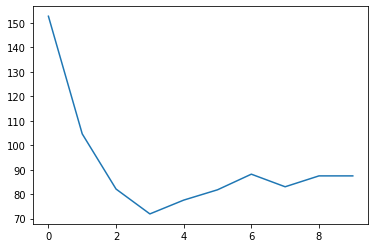

In [45]:
########################## loss plot #######################

import matplotlib.pyplot as plt
x = np.array(range(len(run_report['epoch'])))
y = np.array(run_report['eval_dev_loss'])
plt.plot(x,y)
plt.show()

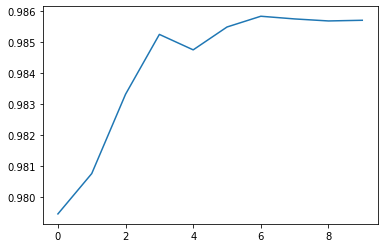

In [46]:
########################## accuracy plot #######################

import matplotlib.pyplot as plt
x = np.array(range(len(run_report['epoch'])))
y = np.array(run_report['eval_dev_acc'])
plt.plot(x,y)
plt.show()